# NFDI demonstrator by Data Analytics in Engineering

Authors: Julius Herb <herb@mib.uni-stuttgart.de>, Sanath Keshav <keshav@mib.uni-stuttgart.de>, Felix Fritzen <fritzen@mib.uni-stuttgart.de>

Website: https://www.mib.uni-stuttgart.de/dae

## Thermal homogenization problem in 2D with periodic boundary conditions

### Introduction

In computational homogenization [1], the overall goal is to determine the effective material behavior of a heterogeneous material based on a given microstructure using numerical simulations.
For that, the microstructure is assumed to be a periodic continuation of a representative volume element (RVE) with the domain $\Omega \subset \mathbb{R}^2$.
The microscopic position in the RVE is denoted by $\boldsymbol{x} \in \Omega$.

Each RVE is assumed to consist of two phases.
Hence, the domain is decomposed into a part of a matrix material $\Omega_0$ and a part of inclusions $\Omega_1$.
Often, the microstructures for homogenization problems are given through images, i.e., each pixel of an image defines the assignment of the corresponding area of the microstructure to one of the two phases.
Hence, it is convenient to use the underlying regular grid of these images as a discretization of the domain $\Omega$.

This demonstrator showcases a thermal homogenization problem of a 2D microstructure.
For this problem, the temperature field $\theta(\boldsymbol{x}) \in \mathbb{R}$ is the primary variable.
Besides, as secondary variables there are the temperature gradient $\boldsymbol{g}(\boldsymbol{x}) = \nabla \theta(\boldsymbol{x}) \in \mathbb{R}^2$ and the heat flux $\boldsymbol{q}(\boldsymbol{x}) \in \mathbb{R}^2$.
These secondary variables are related by Fourier's law:
\begin{equation}
	\boldsymbol{q}(\boldsymbol{x}) = -\boldsymbol{\kappa}(\boldsymbol{x}) \boldsymbol{g}(\boldsymbol{x}) \,,
\end{equation}
where the heat conductivity tensor $\boldsymbol{\kappa}(\boldsymbol{x}) \in \mathrm{Sym} \left( \mathbb{R}^{2 \times 2} \right)$ has to be symmetric and positive definite and is different in each phase.
Often, the heat conduction in each phase is assumed to be isotropic, that is, $\boldsymbol{\kappa}_0 = \kappa_0 \boldsymbol{I} \,, \boldsymbol{\kappa}_1 = \kappa_1 \boldsymbol{I}$ with $\kappa_0, \kappa_1 \in \mathbb{R}$.

The classical approach of solving homogenization problems is using Finite Element Method (FEM) simulations. 

### References:

[1] Fritzen, F. (2011). Microstructural modeling and computational homogenization of the physically linear and nonlinear constitutive behavior of micro-heterogeneous materials. KIT Scientific Publishing. https://doi.org/10.5445/KSP/1000023534 (esp. section 4.2)

[2] Leuschner, M., & Fritzen, F. (2017). Fourier-Accelerated Nodal Solvers (FANS) for homogenization problems. In Computational Mechanics (Vol. 62, Issue 3, pp. 359–392). Springer Science and Business Media LLC. https://doi.org/10.1007/s00466-017-1501-5

[3]

[4]

### Imports

In [1]:
!pip install -r requirements.txt --quiet --disable-pip-version-check
import torch
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import ipywidgets
from utils import *
from plotting import *
import timeit
import time
%matplotlib widget

## Configuration

In [2]:
dtype = torch.float64
torch.set_default_dtype(dtype)
device = "cuda" if torch.cuda.is_available() else "cpu"
args = {"device": device, "dtype": dtype}
print(args)

{'device': 'cuda', 'dtype': torch.float64}


## Initialize data loading

In [3]:
file_path = os.path.join("data", "feature_engineering_data.h5")
group_name = "train_set"

if not os.path.isfile(file_path):
    print("Downloading data from DaRUS...")
    darus_download(repo_id=3366, file_id=4, file_path=file_path)

samples = MicrostructureImageDataset(
    file_path=file_path,
    group_name=group_name
)
print('Number of samples in dataset:', len(samples))

Number of samples in dataset: 30000


## Load microstructure and plot it

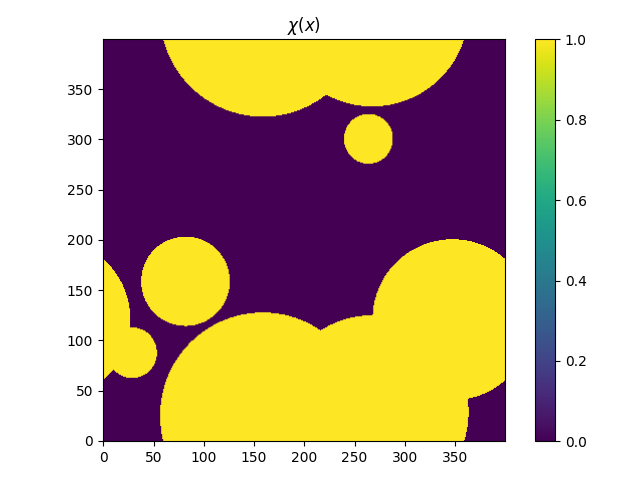

In [4]:
idx = 25
image = samples[idx]

fig, ax = plt.subplots(1, 1)
cax = ax.imshow(image.T.cpu(), origin="lower")
fig.colorbar(cax, ax=ax)
ax.set_title(r"$\chi(x)$")
fig.tight_layout()
plt.show()

## Define material parameters and loading

TODO: introduce material parameters and loading

tensor([[1.0000],
        [0.2000]])


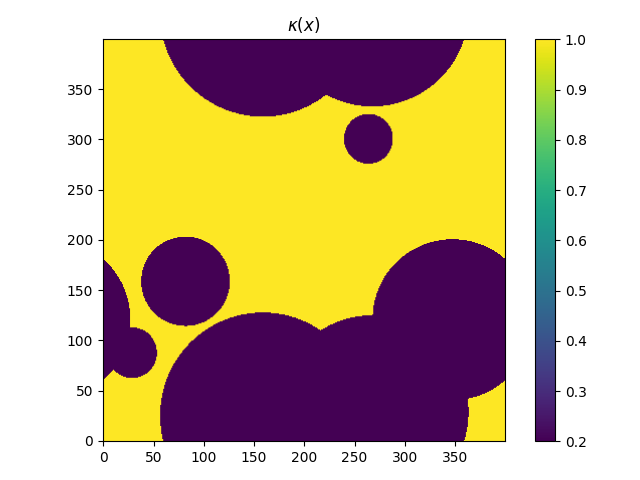

In [5]:
params = torch.tensor([1., 0.2]).reshape(2, 1)
print(params)

assert params.min() > 0, "thermal conductivity has to be positive"
assert (params.min() / params.max() < 0.8), "phase contrast should not be close to 1"

param_field = get_param_fields(image, params).to(**args).unsqueeze(0)
loading = torch.eye(2, **args)

fig, ax = plt.subplots(1, 1)
cax = ax.imshow(param_field[0].T.cpu(), origin="lower")
fig.colorbar(cax, ax=ax)
ax.set_title(r"$\kappa(x)$")
fig.tight_layout()
plt.show()

## Load model and run warm-up

Optionally, the model can be compiled with TorchDynamo/Torchinductor to enable faster execution (set `compile_model=True`). However, the compilation itself takes a few seconds. If the `ipykernel` crashes during compilation or while loading a precompiled model it is recommended to set `compile_model=False`.

Be aware that compilation using TorchDynamo/Torchinductor does not always accelerate the model. Particularly on older NVIDIA architectures it can introduce additional overhead.
Nevertheless, models that have been compiled into a C++ shared library (*.so file) can be also used outside of a Python environment.

In [6]:
model = load_fnocg_model(problem="thermal", dim=2, bc="per", n_layers=15, device=device, dtype=dtype, compile_model=True)

Trying to load precompiled model... Successful


## Run benchmark

Runtime for a single model evaluation should be <10ms on a state-of-the-art NVIDIA GPU, <150ms on an older (or e.g. notebook) NVIDIA GPU, and <600ms on the CPU.

Batched model evaluations are also possible to achieve a high-throughput analysis, but when using TorchDynamo/Torchinductor the model has to be compiled with appropriate settings.

In [7]:
def run_model():
    with torch.inference_mode():
        model(param_field.to(**args), loading.to(**args))
        if device != "cpu":
            torch.cuda.synchronize()

n_runs = 10
for _ in range(3):
    run_model()
model_time = timeit.timeit(run_model, number=n_runs) / n_runs
print(f"Runtime per execution: {model_time*1000.:.4f}ms")

Runtime per execution: 5.3147ms


## Run model to obtain full-field solutions

Shapes of the tensors are as follows:
- `param_field` with material parameter $\kappa(\boldsymbol{x})$: $n_{\mathrm{microstructures}} \times 1 \times 400 \times 400$
- `loading` with macroscopic temperature gradient $\bar{\boldsymbol{g}}$: $n_{\mathrm{loadings}} \times 2$
- `temp` with temperature fluctuations $\tilde{\theta}(\boldsymbol{x})$: $n_{\mathrm{microstructures}} \times n_{\mathrm{loadings}} \times 1 \times 400 \times 400$
- `flux` with heat flux vector-fields $\boldsymbol{q}(\boldsymbol{x})$: $n_{\mathrm{microstructures}} \times n_{\mathrm{loadings}} \times 2 \times 400 \times 400$
- `field` with stacked `temp` and `flux`: $n_{\mathrm{microstructures}} \times n_{\mathrm{loadings}} \times 3 \times 400 \times 400$

In [8]:
with torch.inference_mode():
    field = model(param_field.to(**args), loading.to(**args))
    temp = field[..., :1, :, :].cpu()
    flux = field[..., 1:, :, :].cpu()
print(param_field.shape, loading.shape, temp.shape, flux.shape)

torch.Size([1, 400, 400]) torch.Size([2, 2]) torch.Size([1, 2, 1, 400, 400]) torch.Size([1, 2, 2, 400, 400])


## Visualize loadings using streamlines

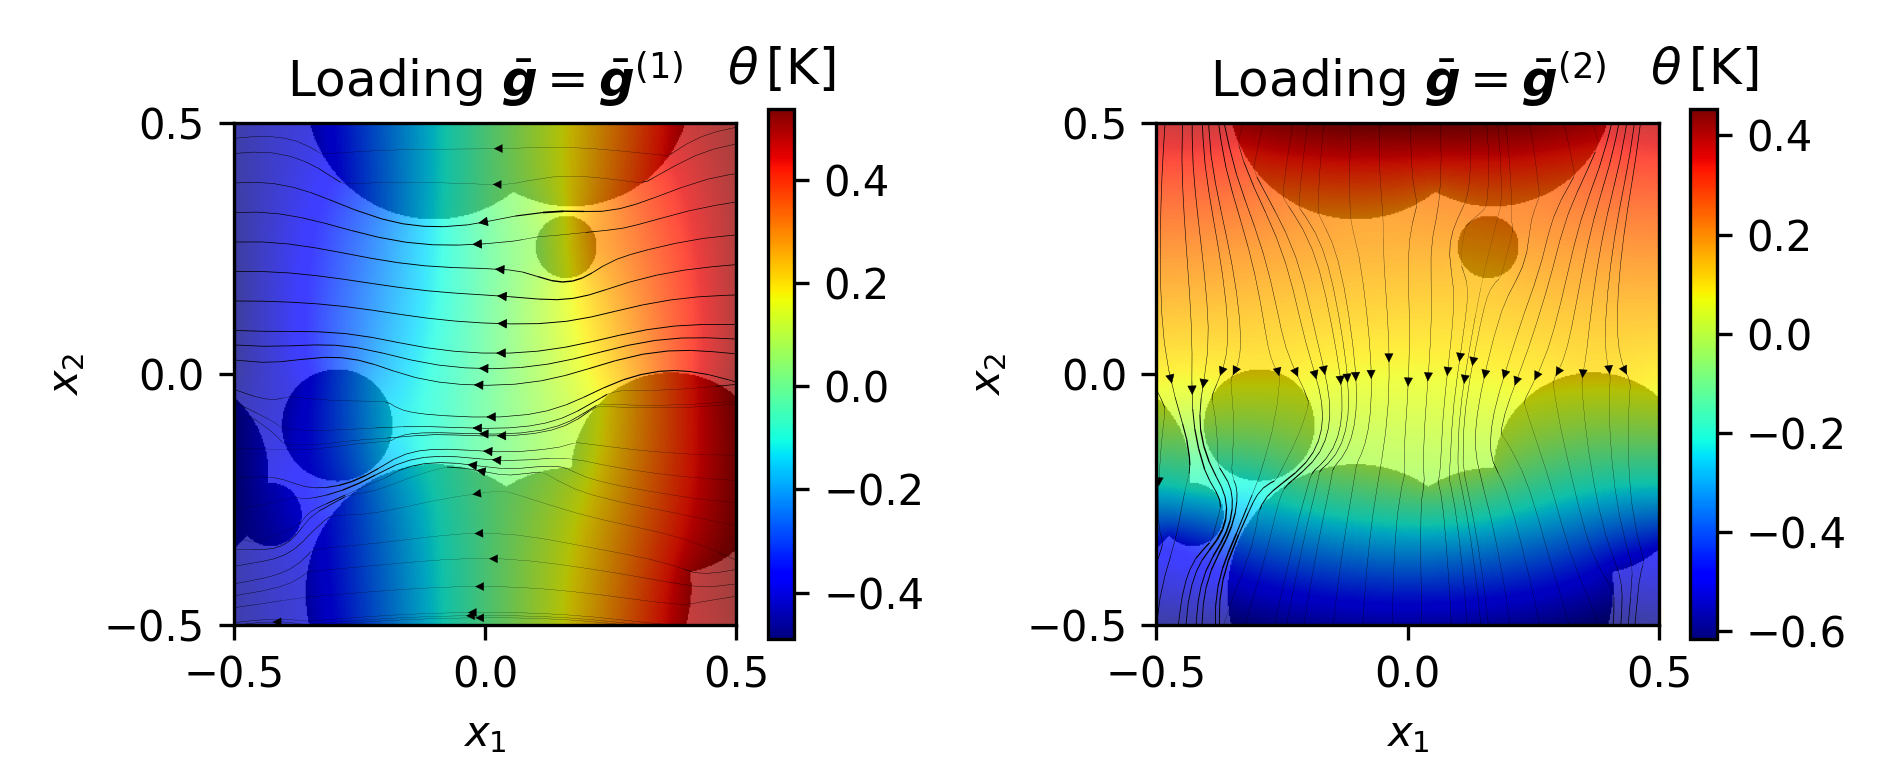

In [9]:
X, Y = get_node_coords(temp)
temp_macro = get_macro_temp(temp[..., :1, :, :], loading.cpu())
loading_names = [r"$\bar{\boldsymbol{g}}=\bar{\boldsymbol{g}}^{(1)}$", r"$\bar{\boldsymbol{g}}=\bar{\boldsymbol{g}}^{(2)}$"]

fig, ax = plt.subplots(1, len(loading_names), figsize=[6.3, 2.6], dpi=300)
for load_i, load_name in enumerate(loading_names):
    pcm = ax[load_i].imshow(temp_macro[0, load_i, 0].T.cpu().numpy(), origin="lower", extent=[-0.5, 0.5, -0.5, 0.5], cmap="jet")
    clb = plt.colorbar(pcm, ax=ax[load_i])
    clb.ax.set_title(r"$\theta \,\mathrm{[K]}$")
    ax[load_i].imshow(image.T.cpu().numpy(), origin="lower", extent=[-0.5, 0.5, -0.5, 0.5], cmap="Greys", alpha=0.25, rasterized=True)
    flux_mag = flux[0].norm(dim=-3)[load_i].T
    lw = flux_mag * 0.5 / flux_mag.max().item()
    ax[load_i].streamplot(X.cpu().numpy(), Y.cpu().numpy(), flux[0, load_i, 0].T.cpu().numpy(), flux[0, load_i, 1].T.numpy(), color='k', density=0.6, broken_streamlines=False, linewidth=lw.numpy(), arrowsize=0.5)
    ax[load_i].set_title(rf"Loading {load_name}")
for ax_handle in ax.ravel():
    ax_handle.set_xlim(-0.5, 0.5)
    ax_handle.set_ylim(-0.5, 0.5)
    ax_handle.set_xticks([-0.5, 0.0, 0.5])
    ax_handle.set_yticks([-0.5, 0.0, 0.5])
    ax_handle.set_xlabel(r"$x_1$")
    ax_handle.set_ylabel(r"$x_2$")
plt.tight_layout()
plt.show()

### Plot temperature fluctuation fields:

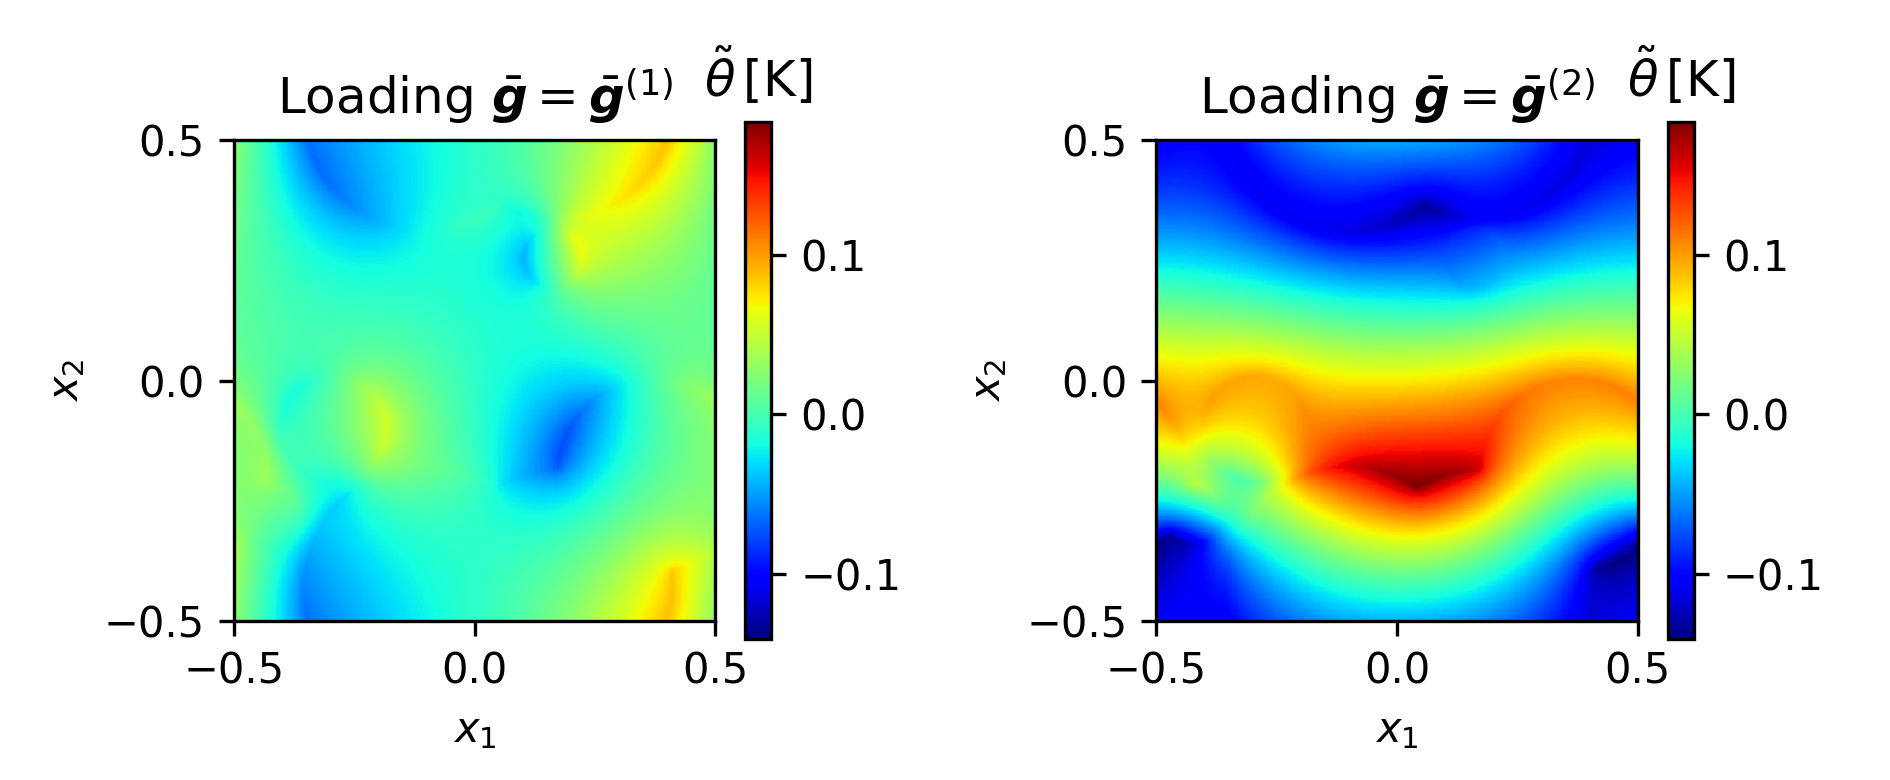

In [10]:
fig, ax = plt.subplots(1, 2, figsize=[6.3, 2.6], dpi=300)
plot_channel(temp[0,0], temp[0,1], channel=0, ax=ax, cmap="jet", plot_error=False, cbar_label=r"$\tilde{\theta} \,\mathrm{[K]}$")

for load_i, load_name in enumerate(loading_names):
    ax[load_i].set_title(rf"Loading {load_name}")#
for ax_handle in ax.ravel():
    ax_handle.axis('on')
    ax_handle.set_xlim(-0.5, 0.5)
    ax_handle.set_ylim(-0.5, 0.5)
    ax_handle.set_xticks([-0.5, 0.0, 0.5])
    ax_handle.set_yticks([-0.5, 0.0, 0.5])
    ax_handle.set_xlabel(r"$x_1$")
    ax_handle.set_ylabel(r"$x_2$")
plt.tight_layout()
plt.show()

### Plot heat flux fields:

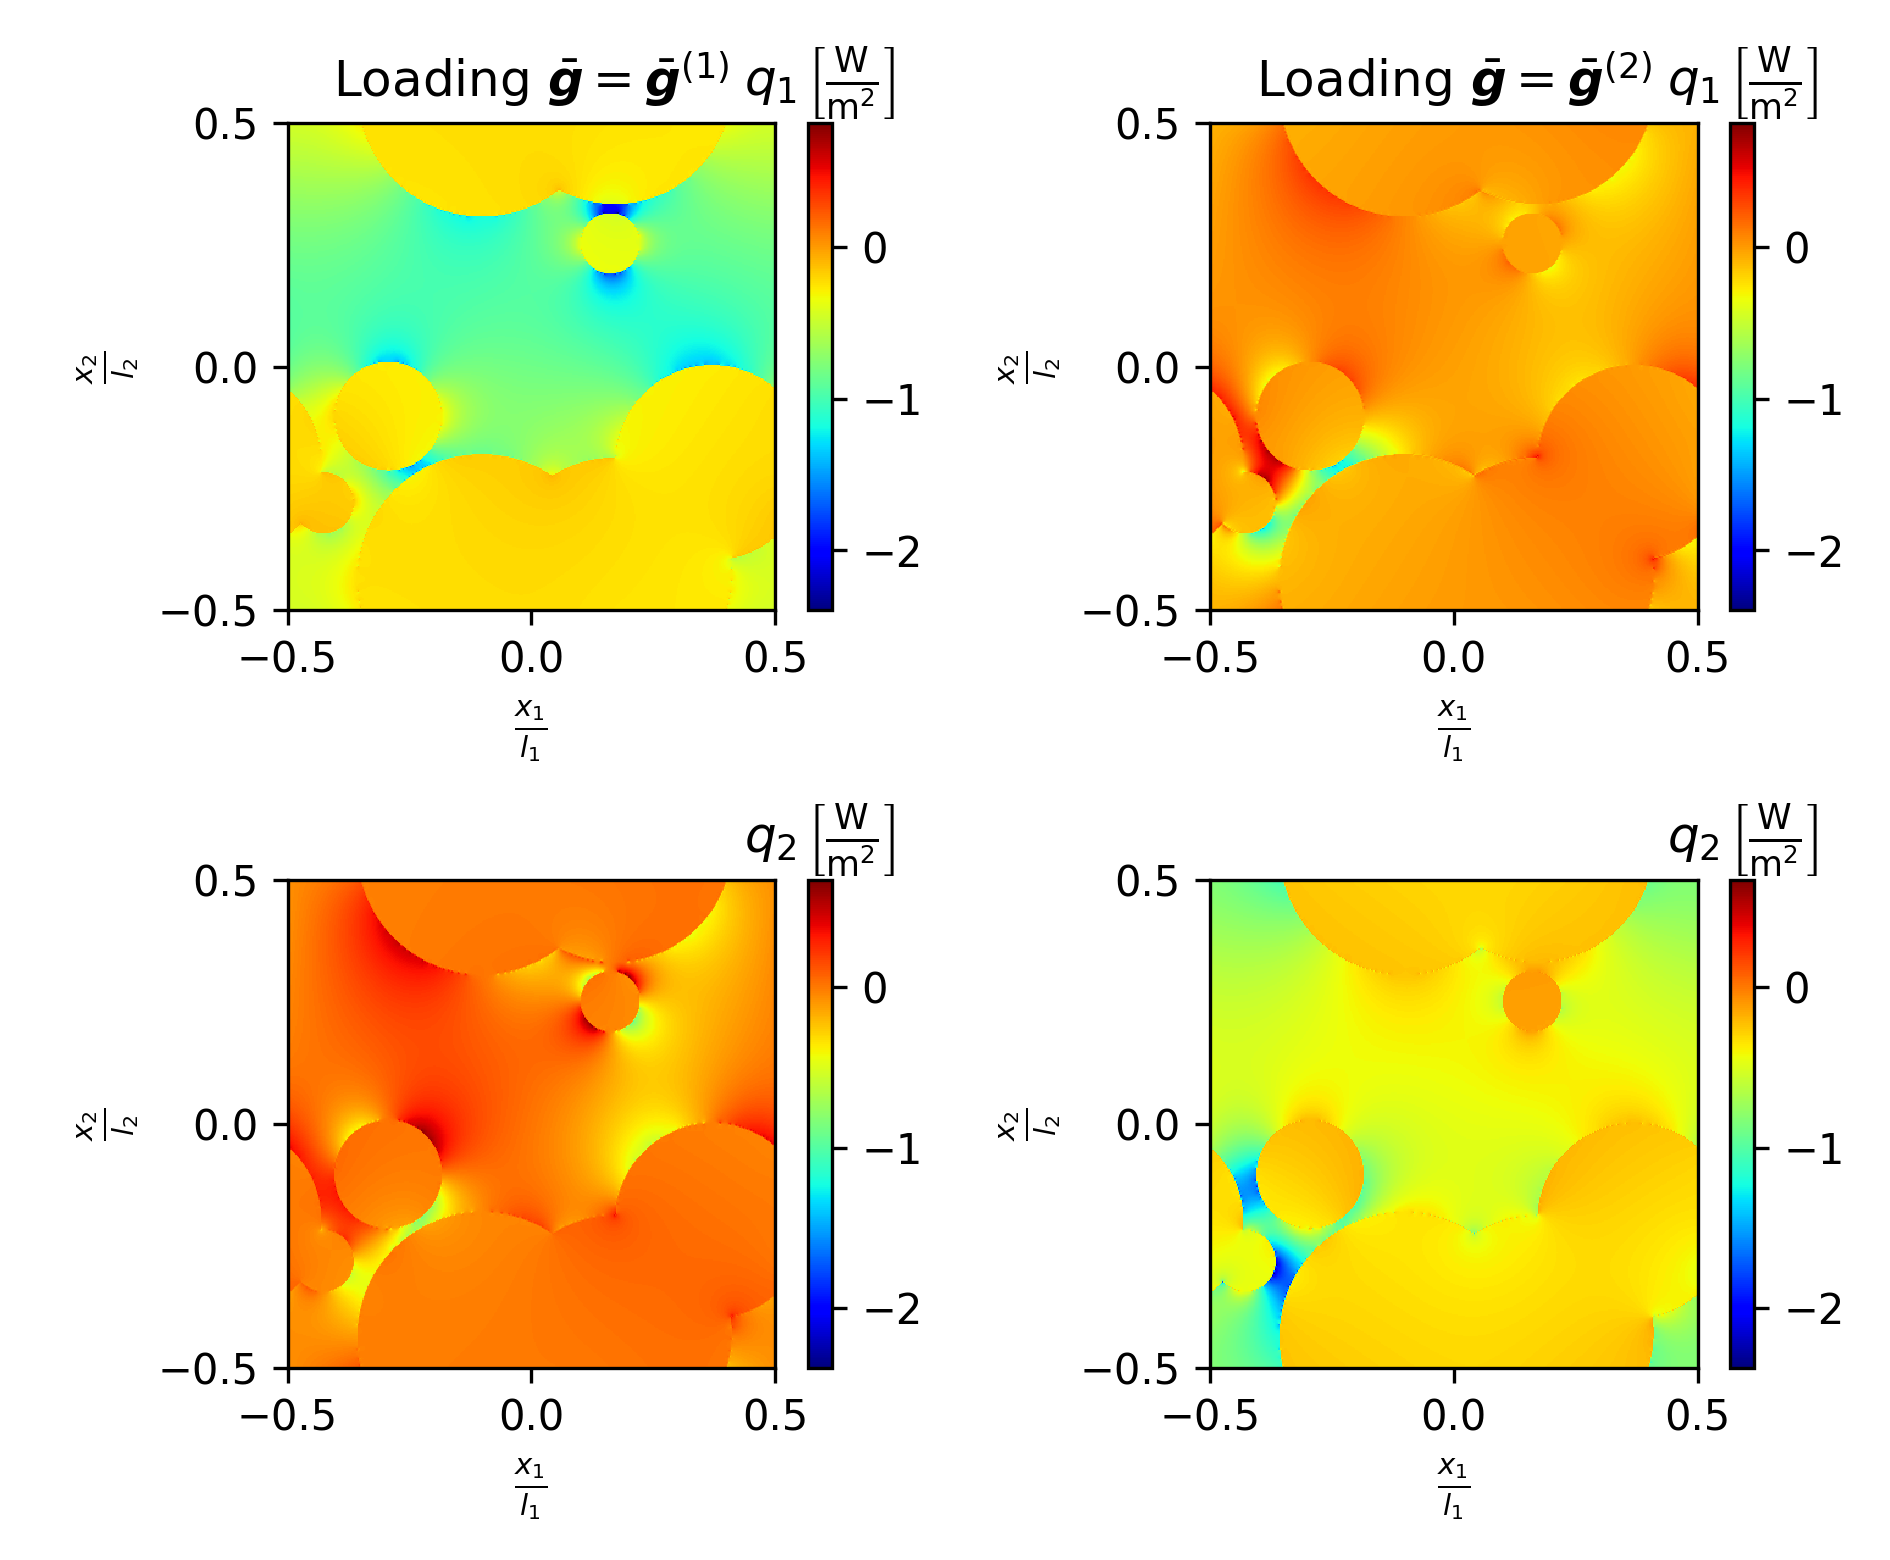

In [11]:
fig, ax = plt.subplots(2, 2, figsize=[6.3, 5.2], dpi=300)
plot_channel(flux[0,0], flux[0,1], channel=0, ax=ax[0], cmap="jet", plot_error=False, cbar_label=r"$q_1 \,\mathrm{\left[ \frac{W}{m^2} \right]}$", centered=False)
plot_channel(flux[0,0], flux[0,1], channel=1, ax=ax[1], cmap="jet", plot_error=False, cbar_label=r"$q_2 \,\mathrm{\left[ \frac{W}{m^2} \right]}$", centered=False)

for load_i, load_name in enumerate(loading_names):
    ax[0, load_i].set_title(rf"Loading {load_name}")#
for ax_handle in ax.ravel():
    ax_handle.axis('on')
    ax_handle.set_xlim(-0.5, 0.5)
    ax_handle.set_ylim(-0.5, 0.5)
    ax_handle.set_xticks([-0.5, 0.0, 0.5])
    ax_handle.set_yticks([-0.5, 0.0, 0.5])
    ax_handle.set_xlabel(r"$\frac{x_1}{l_1}$")
    ax_handle.set_ylabel(r"$\frac{x_2}{l_2}$")
plt.tight_layout()
plt.show()

### Homogenized response

$$ \bar{\boldsymbol{q}} = - \bar{\boldsymbol{\kappa}} \bar{\boldsymbol{g}} $$

In [12]:
kappa_bar = -homogenize(flux).squeeze()
print('Homogenized kappa:', kappa_bar, sep='\n')
print('eig(kappa): ', torch.linalg.eigvals(kappa_bar).real)

Homogenized kappa:
tensor([[0.5470, 0.0105],
        [0.0105, 0.4322]])
eig(kappa):  tensor([0.5479, 0.4312])


### Voigt-Reuss bounds

Simple theoretical upper and lower bounds for the eigenvalues of the effective heat conductivity tensor $\bar{\boldsymbol{\kappa}}$ are available through the Voigt-Reuss bounds $\kappa_\mathrm{ub}$ and $\kappa_\mathrm{lb}$, which depend only on the volume fractions ($f_0$, $f_1$) and the material parameters ($\kappa_0$, $\kappa_1$). They are defined as
\begin{equation}
	\kappa_\mathrm{reuss} = \left( f_0 \kappa_0^{-1} + f_1 \kappa_1^{-1} \right)^{-1}
	\leq \mathrm{eig}\left( \bar{\boldsymbol{\kappa}} \right) \leq
	f_0 \kappa_0 + f_1 \kappa_1 = \kappa_\mathrm{voigt} \,.
\end{equation}

In [13]:
vol_frac = homogenize(image)
reuss = 1. / (vol_frac / params[1] + (1. - vol_frac) / params[0])
voigt = vol_frac * params[1] + (1. - vol_frac) * params[0]
print(f"reuss = {reuss.item():.4f} <= eig(kappa) <= {voigt.item():.4f} = voigt")

reuss = 0.3442 <= eig(kappa) <= 0.6189 = voigt


## Interactive widget for the thermal homogenization problem

This interactive widget allows the user to play around with different paramaters of the homogenization problem and solve it in real-time to observe their implications.
In the background, a high-fidelity simulation using the FEM on a 400x400 grid (given directly by the microstructure) is carried out on the GPU using our *FANS-CG* solver that features a special FFT-based preconditioner tailored to this problem.
At the moment, the bottleneck of the interactive widget is not the simulation itself (about 5-10ms on a state-of-the-art GPU) but rather the visualization using matplotlib (>200ms).
With GPU-accelerated rendering via e.g. OpenCV, this could be improved greatly.

The homogenization problem is solved for two orthogonal load cases (load case 1 with $\bar{\boldsymbol{g}}=\bar{\boldsymbol{g}}^{(1)}$ and load case 2 with $\bar{\boldsymbol{g}}=\bar{\boldsymbol{g}}^{(2)}$) in order to determine the homogenized response, i.e., the effective thermal conductivity $\bar{\boldsymbol{\kappa}} \; \mathrm{[W/m^2]}$ based on a given microstructure and given phase-wise material parameters $\kappa_0, \kappa_1 \; \mathrm{[W/m^2]}$.
For simplicity, the thermal conductivity of the matrix material $\kappa_0 = 1 \; \mathrm{[W/m^2]}$ is fixed (since this is a linear problem that can be scaled arbitrarily) and the conductivity of the inclusion phase can be varied between $0.1 \leq \kappa_1 \leq 0.9 \; \mathrm{[W/m^2]}$.
In this version of the demonstrator, the user can choose between 30000 randomly generated microstructures (Microstructure id: 0-29999) with a resolution of 400x400.
In the future, it may be interesting to provide users with the ability to draw microstructures on the fly or to upload their own images.

Besides, the temperature fluctuation fields $\tilde{\theta} \; \mathrm{[K]}$, the magnitude of the heat fluxes $||\boldsymbol{q}|| \; \mathrm{[W/m^2]}$ is shown for each load case.
Above, the effective thermal conductivity $\bar{\boldsymbol{\kappa}} \; \mathrm{[W/m^2]}$ (which is a spd second-order tensor) is visualized.
For that, its eigenvalues $\mathrm{eig}(\bar{\boldsymbol{\kappa}}) \; \mathrm{[W/m^2]}$ are plotted along the theoretical Voigt/Reuss bounds and the phase-wise material parameters $\kappa_0, \kappa_1 \; \mathrm{[W/m^2]}$.
As one can observe, the eigenvalues depend highly on the microstructure and the given material parameters. However, they are always within the Voigt/Reuss bounds.
In addition to the material parameter $\kappa_1 \; \mathrm{[W/m^2]}$ and the microstructure id, the user can define the direction of the macroscopic temperature gradients $\bar{\boldsymbol{g}} \; \mathrm{[-]}$ that are imposed as loadings via the angle $\alpha \; [°]$:
\begin{equation}
    \bar{\boldsymbol{g}}^{(1)} = \begin{bmatrix} \cos \alpha \\ -\sin \alpha \end{bmatrix} \,, \quad \bar{\boldsymbol{g}}^{(2)} = \begin{bmatrix} \sin \alpha \\ \cos \alpha \end{bmatrix}
\end{equation}
While this parameter has a great effect on the full-field solutions of the heat fluxes and temperature fluctuations, the effective thermal conductivity is independent of them as expected.

Times: preprocessing 1.6613ms, simulation 5.5101ms, postprocessing 1.1444ms, plotting 221.8139ms


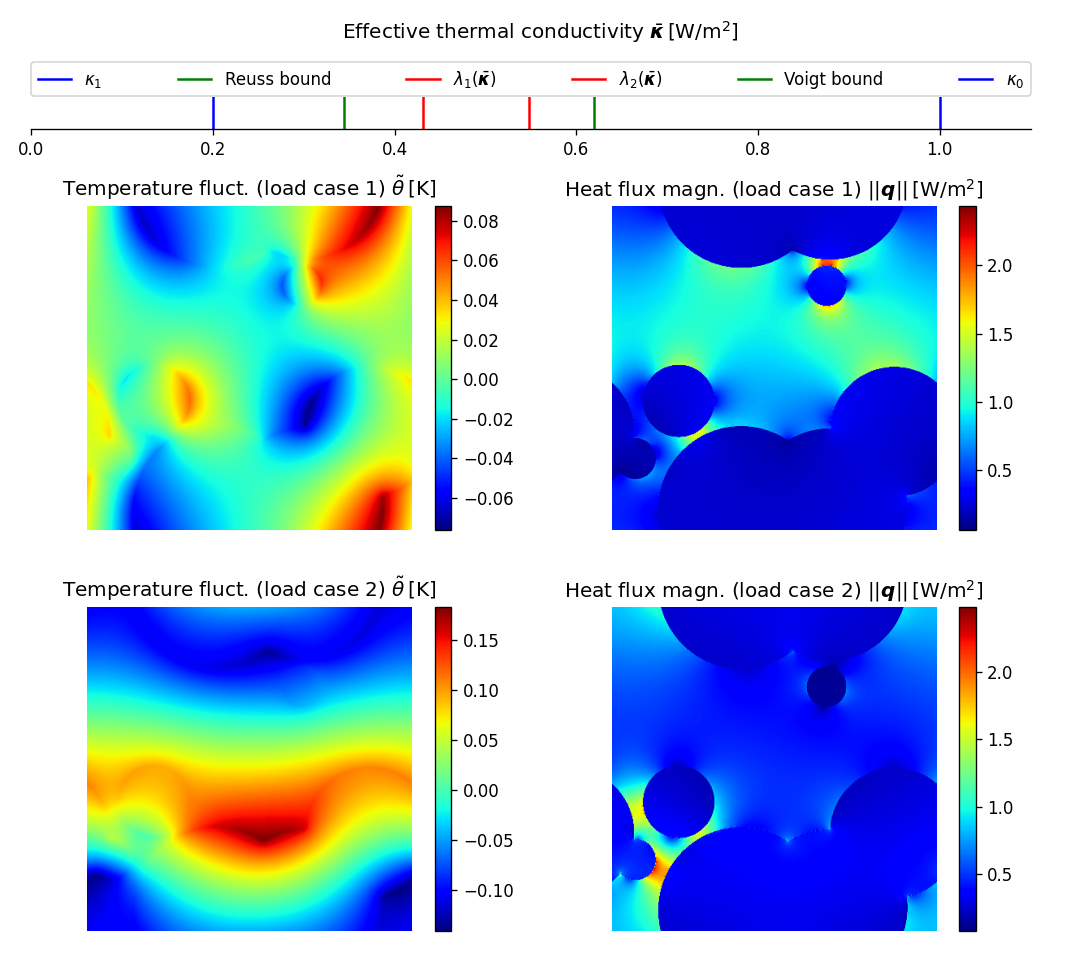

In [14]:
widget = ThermalWidget(samples=samples, model=model, device=device, dtype=dtype, show_colorbars=True, figsize=[9,8], dpi=120)
slider_args = {"continuous_update": False}  # for a more interactive UX this could be set to True
ms_input = ipywidgets.BoundedIntText(value=25, min=0, max=len(samples) - 1, step=1, description='Microstructure id:', disabled=False,
                                     style={'description_width': 'initial'}, layout = ipywidgets.Layout(width='200px'))
kappa1_slider = ipywidgets.FloatSlider(min=0.1, max=0.9, step=0.01, value=0.2, **slider_args, description=r"$\kappa_1 \; \mathrm{[W/m^2]}$")
alpha_slider = ipywidgets.IntSlider(min=0, max=90, step=1, value=0, **slider_args, description=r"$\alpha \; [°]$")

widget.update(ms_input.value, kappa1_slider.value, alpha_slider.value)  # dry-run
widget.update(ms_input.value, kappa1_slider.value, alpha_slider.value, print_times=True)  # benchmark
interactive_plot = ipywidgets.interactive(widget.update, ms_id=ms_input, kappa1=kappa1_slider, alpha=alpha_slider)
display(ipywidgets.HBox([ms_input, kappa1_slider, alpha_slider]))
plt.show()